# Deep Reinforcement Learning for Stock Trading
This project implements a Deep Q-Network (DQN) to optimize stock trading decisions based on historical price data. It uses **Google stock price data** (`googl.us.txt`), applying technical indicators like **MACD and RSI**, along with normalized returns, to construct a state representation.

### **State Space**
Each state consists of the past **60 time steps** of:
- **Normalized closing prices**
- **MACD & RSI indicators**
- **Monthly, Bi-Monthly, Quarterly, and Annual returns (normalized by volatility)**

### **Action Space**
The agent can take **three discrete actions**:
1. **Hold (0)**
2. **Buy (1)**
3. **Sell (2)**

### **Reward Function**
The reward is based on the price change, risk-adjusted returns, and trading costs, formulated as:

$$
R_t = \mu \left[ \left( \frac{\sigma_{tgt}}{\sigma_{t-1}} A_{t-1} \right) r_t + \left( -C \cdot p_{t-1} \right) \cdot \left| \left( \frac{\sigma_{tgt}}{\sigma_{t-1}} A_{t-1} - \frac{\sigma_{tgt}}{\sigma_{t-2}} A_{t-2} \right) \right| \right]
$$


### **Training Process**
- The agent is trained using **experience replay** and **target networks** for stable learning.
- The **loss function** is **MSE**, and the optimizer is **Adam**.
- **Epsilon-greedy exploration** is used to balance exploration vs. exploitation.
- The model is updated every **500 steps**, and the agent trains for **100 epochs** with **batch size 256**.

This setup enables the agent to learn an optimal trading strategy through reinforcement learning.


# Code

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# Data Preprocessing

In [2]:
# Compute MACD and RSI
def compute_macd_rsi(data):
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data.fillna(0, inplace=True)
    return data

# Compute returns normalized by volatility
def compute_returns(data):
    vol = data['Close'].pct_change().rolling(60).std()
    data['MonthlyReturn'] = (data['Close'].pct_change(21) / (vol * np.sqrt(21))).fillna(0)
    data['BiMonthlyReturn'] = (data['Close'].pct_change(42) / (vol * np.sqrt(42))).fillna(0)
    data['QuarterlyReturn'] = (data['Close'].pct_change(63) / (vol * np.sqrt(63))).fillna(0)
    data['AnnualReturn'] = (data['Close'].pct_change(252) / (vol * np.sqrt(252))).fillna(0)
    return data

# Preprocess dataset
def preprocess_data(data):
    data['Close_Norm'] = data['Close'] / data['Close'].max()
    data = compute_macd_rsi(data)
    data = compute_returns(data)
    return data

# Exponentially Weighted Moving Average (EWMA) Standard Deviation
def ewma_std(prices, window=60):
    return prices.ewm(span=window).std()



# State space

In [3]:
def get_state(data, t):
    if t < 60:
        return None
    return np.concatenate([
        data['Close_Norm'].values[t-60:t],
        data['MonthlyReturn'].values[t-60:t],
        data['BiMonthlyReturn'].values[t-60:t],
        data['QuarterlyReturn'].values[t-60:t],
        data['AnnualReturn'].values[t-60:t],
        data['MACD'].values[t-60:t],
        data['RSI'].values[t-60:t]
    ])

# Deep Q-Network (DQN) Class


In [4]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Experience Replay Buffer


In [5]:
class ExperienceReplay:
    def __init__(self, capacity=10000):
        self.memory = []
        self.capacity = capacity

    def push(self, state, action, reward, next_state):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Reward Calculation Function


$$
R_t = \mu \left[ \left( \frac{\sigma_{tgt}}{\sigma_{t-1}} A_{t-1} \right) r_t + \left( -C \cdot p_{t-1} \right) \cdot \left| \left( \frac{\sigma_{tgt}}{\sigma_{t-1}} A_{t-1} - \frac{\sigma_{tgt}}{\sigma_{t-2}} A_{t-2} \right) \right| \right]
$$

In [6]:
def calculate_reward(pt, pt_1, pt_2, At_1, At_2, sigma_t, sigma_t_1, sigma_t_2, sigma_tgt=1, C=0.0001, mu=1):
    rt = pt - pt_1
    term1 = (sigma_tgt / sigma_t_1) * At_1 * rt
    term2 = -C * pt_1
    term3 = (sigma_tgt / sigma_t_1) * At_1 - (sigma_tgt / sigma_t_2) * At_2
    return mu * (term1 + (term2 * abs(term3)))


# Training Function


In [7]:
def train(data, agent, replay_buffer, optimizer, epochs=5, batch_size=32, gamma=0.99,
          sigma_tgt=1, cost_rate=0.0001, epsilon_start=1.0, epsilon_end=0.01,
          epsilon_decay=0.995, target_update_freq=100):
    prices = data['Close'].values
    sigma = ewma_std(pd.Series(prices), window=60).values
    sigma[np.isnan(sigma)] = sigma_tgt

    # Initialize target network
    target_agent = DQN(agent.state_dim, agent.action_dim)
    target_agent.load_state_dict(agent.state_dict())
    target_agent.eval()

    loss_fn = nn.MSELoss()
    all_rewards = []
    all_decisions = []
    epoch_losses = []
    step_counter = 0

    epsilon = epsilon_start

    for epoch in range(epochs):
        total_reward = 0
        total_loss = 0
        At_1, At_2 = 0, 0
        pt_1, pt_2 = prices[0], prices[0]
        cumulative_rewards = []
        decisions = []

        for t in range(60, len(prices)):
            state = get_state(data, t-1)
            if state is None:
                continue
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.randint(0, agent.action_dim - 1)
            else:
                with torch.no_grad():
                    q_values = agent(state_tensor)
                action = torch.argmax(q_values).item()

            # Execute action and get reward
            reward = calculate_reward(
                pt=prices[t], pt_1=pt_1, pt_2=pt_2,
                At_1=action, At_2=At_2,
                sigma_t=sigma[t], sigma_t_1=sigma[t-1], sigma_t_2=sigma[t-2],
                sigma_tgt=sigma_tgt, C=cost_rate
            )

            # Store transition
            next_state = get_state(data, t)
            if next_state is not None:
                replay_buffer.push(state, action, reward, next_state)

            # Update tracking variables
            total_reward += reward
            cumulative_rewards.append(total_reward)
            decisions.append(action)
            pt_2, pt_1 = pt_1, prices[t]
            At_2, At_1 = At_1, action

            # Train with batches
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states = zip(*batch)

                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)

                # Current Q-values
                q_values = agent(states).gather(1, actions.unsqueeze(1)).squeeze()

                # Target Q-values
                with torch.no_grad():
                    next_q_values = target_agent(next_states).max(1)[0]

                targets = rewards + gamma * next_q_values

                # Calculate loss
                loss = loss_fn(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                step_counter += 1

                # Update target network
                if step_counter % target_update_freq == 0:
                    target_agent.load_state_dict(agent.state_dict())

        # Epoch tracking
        all_rewards.append(cumulative_rewards)
        all_decisions.append(decisions)
        epoch_losses.append(total_loss)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        if (epoch+1) % 5 == 0:
          print(f"Epoch {epoch+1}/{epochs} | Total Reward: {total_reward:.2f} | Loss: {total_loss:.2f} | Epsilon: {epsilon:.3f}")

    return all_rewards, all_decisions, epoch_losses




# Main Execution: Training the DQN Agent


In [8]:
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('googl.us.txt', parse_dates=['Date'], index_col='Date')
    data = preprocess_data(data)
    state_dim = 60*7 # 60 observations of 7 features
    action_dim = 3  # Hold(0), Buy(1), Sell(2)
    agent = DQN(state_dim, action_dim)
    optimizer = optim.Adam(agent.parameters(), lr=0.0005)
    replay_buffer = ExperienceReplay(capacity=10000)

    # Train
    all_rewards, all_decisions, epoch_losses = train(
        data, agent, replay_buffer, optimizer,
        epochs=100,
        batch_size=256,
        target_update_freq=500,
        gamma=0.99,
        epsilon_decay=0.995
    )


<ipython-input-7-ee3ec14bb792>:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Epoch 5/100 | Total Reward: 97.19 | Loss: 355.92 | Epsilon: 0.975
Epoch 10/100 | Total Reward: 87.91 | Loss: 283.29 | Epsilon: 0.951
Epoch 15/100 | Total Reward: 76.99 | Loss: 233.28 | Epsilon: 0.928
Epoch 20/100 | Total Reward: 109.09 | Loss: 195.28 | Epsilon: 0.905
Epoch 25/100 | Total Reward: 115.92 | Loss: 185.61 | Epsilon: 0.882
Epoch 30/100 | Total Reward: 152.46 | Loss: 134.29 | Epsilon: 0.860
Epoch 35/100 | Total Reward: 160.30 | Loss: 126.21 | Epsilon: 0.839
Epoch 40/100 | Total Reward: 140.89 | Loss: 98.51 | Epsilon: 0.818
Epoch 45/100 | Total Reward: 157.07 | Loss: 83.74 | Epsilon: 0.798
Epoch 50/100 | Total Reward: 202.36 | Loss: 74.63 | Epsilon: 0.778
Epoch 55/100 | Total Reward: 205.63 | Loss: 65.59 | Epsilon: 0.759
Epoch 60/100 | Total Reward: 251.95 | Loss: 60.20 | Epsilon: 0.740
Epoch 65/100 | Total Reward: 216.40 | Loss: 52.04 | Epsilon: 0.722
Epoch 70/100 | Total Reward: 231.98 | Loss: 50.05 | Epsilon: 0.704
Epoch 75/100 | Total Reward: 273.25 | Loss: 51.01 | Epsilon

# Plots

In [9]:
def plot_results(data, all_rewards, all_decisions, epoch_losses):
    prices = data['Close'].values
    dates = data.index

    plt.figure(figsize=(14, 12))

    # Cumulative Returns Across Epochs
    plt.subplot(3, 1, 1)
    for epoch, rewards in enumerate(all_rewards):
        # Adjust the x-axis data to match the length of rewards
        plt.plot(dates[60:60+len(rewards)], rewards, alpha=0.5, label=f'Epoch {epoch+1}' if epoch < 3 else "")
    plt.title('Cumulative Returns Across Epochs')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)

    # Final Epoch Decisions
    plt.subplot(3, 1, 2)
    final_decisions = np.array(all_decisions[-1])
    # Adjust the x-axis data to match the length of final_decisions
    scatter = plt.scatter(dates[60:60+len(final_decisions)], prices[60:60+len(final_decisions)], c=final_decisions, cmap='viridis', s=5)
    plt.colorbar(scatter, label='Action (0=Hold, 1=Buy, 2=Sell)')
    plt.title('Final Epoch Decisions')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)

    # Price Series
    plt.subplot(3, 1, 3)
    plt.plot(dates, prices, color='blue', linewidth=1.5)
    plt.title('Price Series')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Training Metrics
    plt.figure(figsize=(12, 5))

    # Plot Training Loss per Epoch
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, marker='o', linestyle='-', color='red')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Box Plot of Final Cumulative Rewards
    final_rewards = [rewards[-1] for rewards in all_rewards]
    plt.subplot(1, 2, 2)
    plt.boxplot(final_rewards, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title('Final Cumulative Rewards Distribution')
    plt.ylabel('Final Reward')
    plt.xticks([1], ['Final Rewards'])

    plt.tight_layout()
    plt.show()

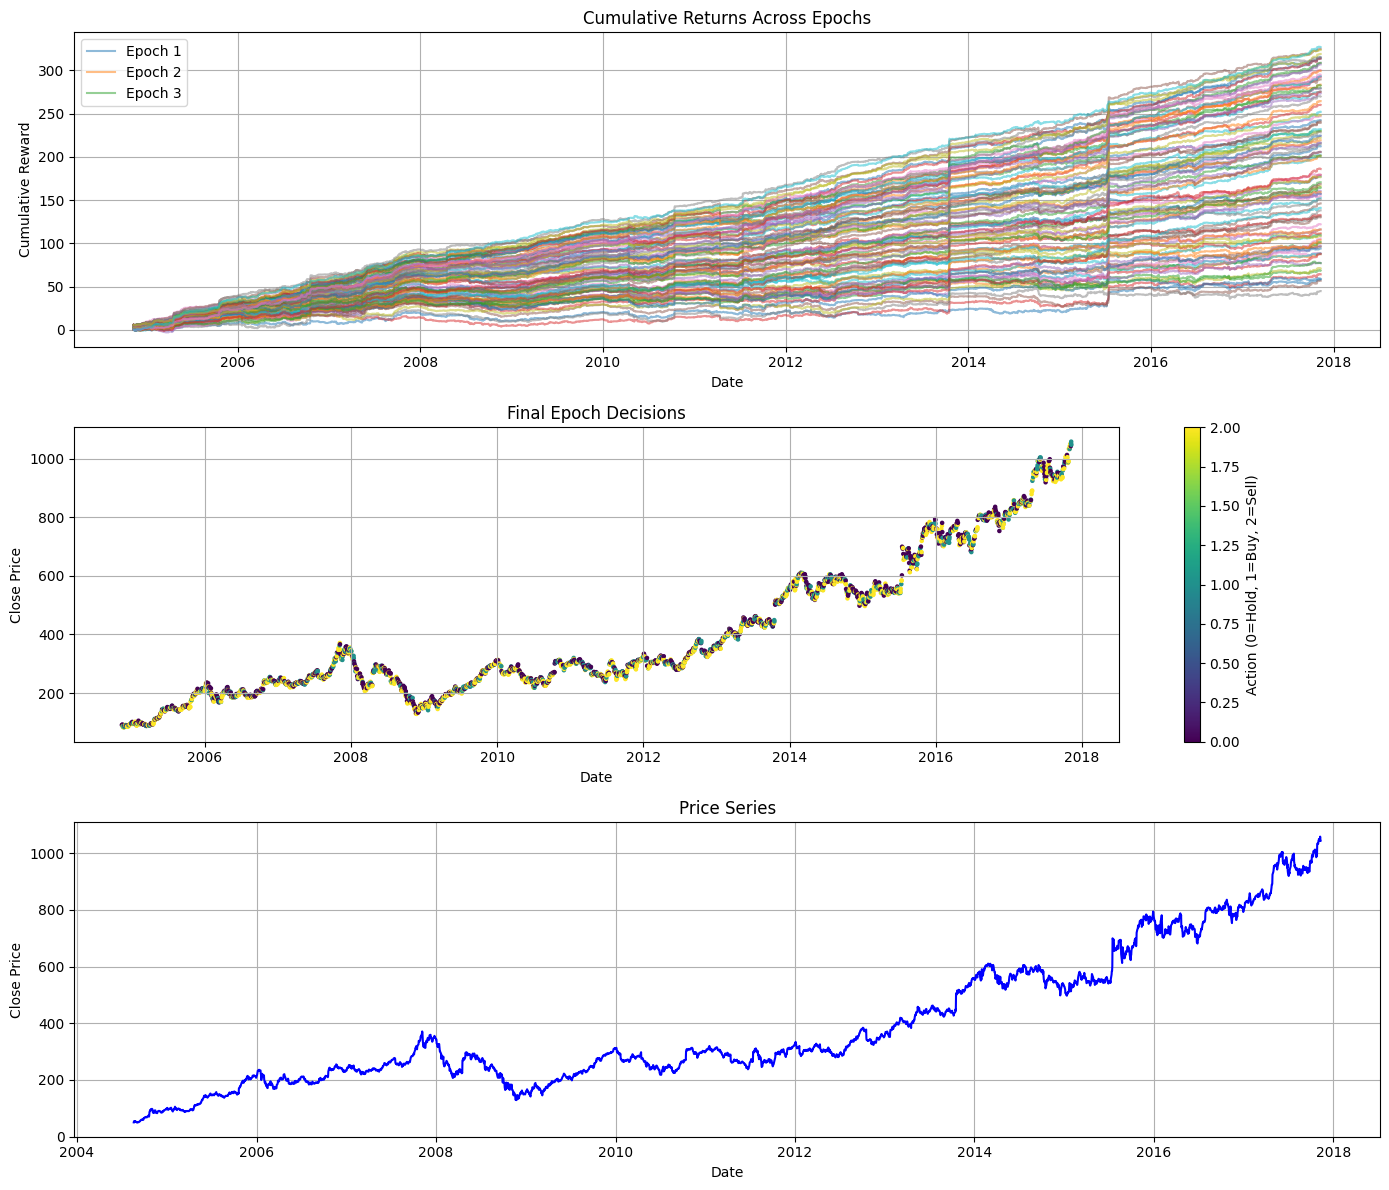

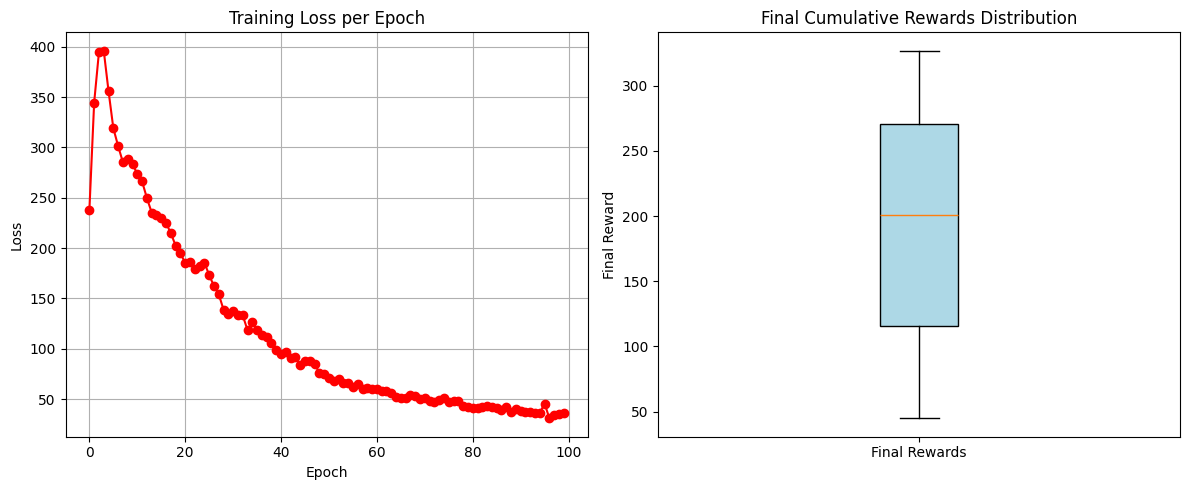

In [10]:
plot_results(data, all_rewards, all_decisions, epoch_losses)

# Save model and other parameters

In [12]:
import pickle

def save_model(agent, filename="dqn_trading_model.pth"):
    torch.save(agent.state_dict(), filename)
    print(f"Model saved as {filename}")

def save_training_data(all_rewards, all_decisions, epoch_losses, filename="training_data.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump({'all_rewards': all_rewards, 'all_decisions': all_decisions, 'epoch_losses': epoch_losses}, f)
    print(f"Training data saved as {filename}")

save_model(agent)
save_training_data(all_rewards, all_decisions, epoch_losses)

Model saved as dqn_trading_model.pth
Training data saved as training_data.pkl


# Additional plots

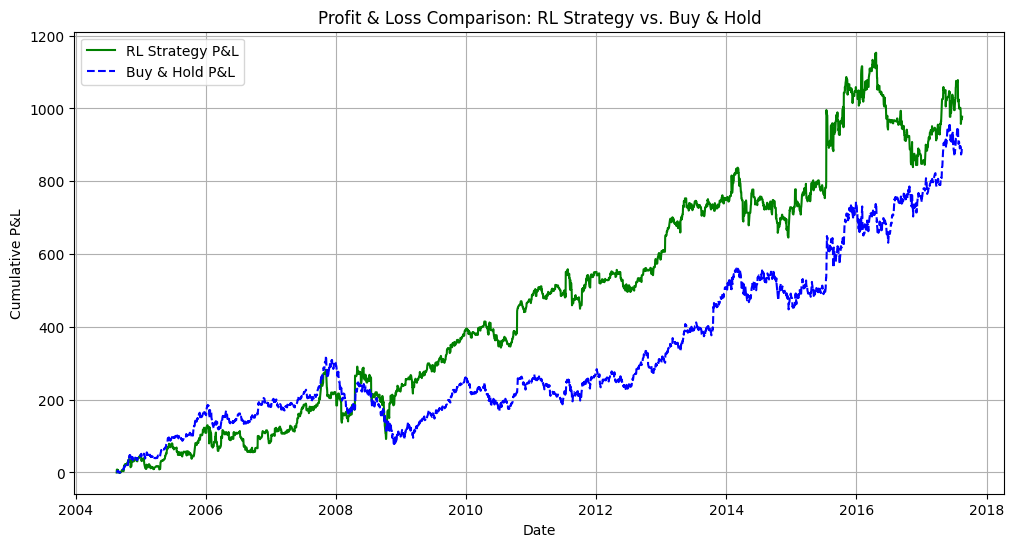

In [17]:
def compare_pnl(decisions, prices):
    prices = np.array(prices)
    decisions = np.array(decisions)

    # Align lengths
    min_length = min(len(prices) - 1, len(decisions))
    prices = prices[:min_length + 1]
    decisions = decisions[:min_length]

    # RL Strategy P&L
    rl_pnl = np.cumsum(np.diff(prices) * decisions)

    # Buy & Hold P&L (simply holding from first price)
    buy_hold_pnl = prices[:min_length] - prices[0]

    return np.insert(rl_pnl, 0, 0), np.insert(buy_hold_pnl, 0, 0)


def plot_pnl_comparison(data, all_decisions):
    prices = data['Close'].values
    dates = data.index

    # Get P&L for both strategies
    final_decisions = np.array(all_decisions[-2])
    rl_pnl, buy_hold_pnl = compare_pnl(final_decisions, prices)

    # Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(dates[:len(rl_pnl)], rl_pnl, label="RL Strategy P&L", color="green")
    plt.plot(dates[:len(buy_hold_pnl)], buy_hold_pnl, label="Buy & Hold P&L", color="blue", linestyle="dashed")

    plt.title("Profit & Loss Comparison: RL Strategy vs. Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Cumulative P&L")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pnl_comparison(data, all_decisions)

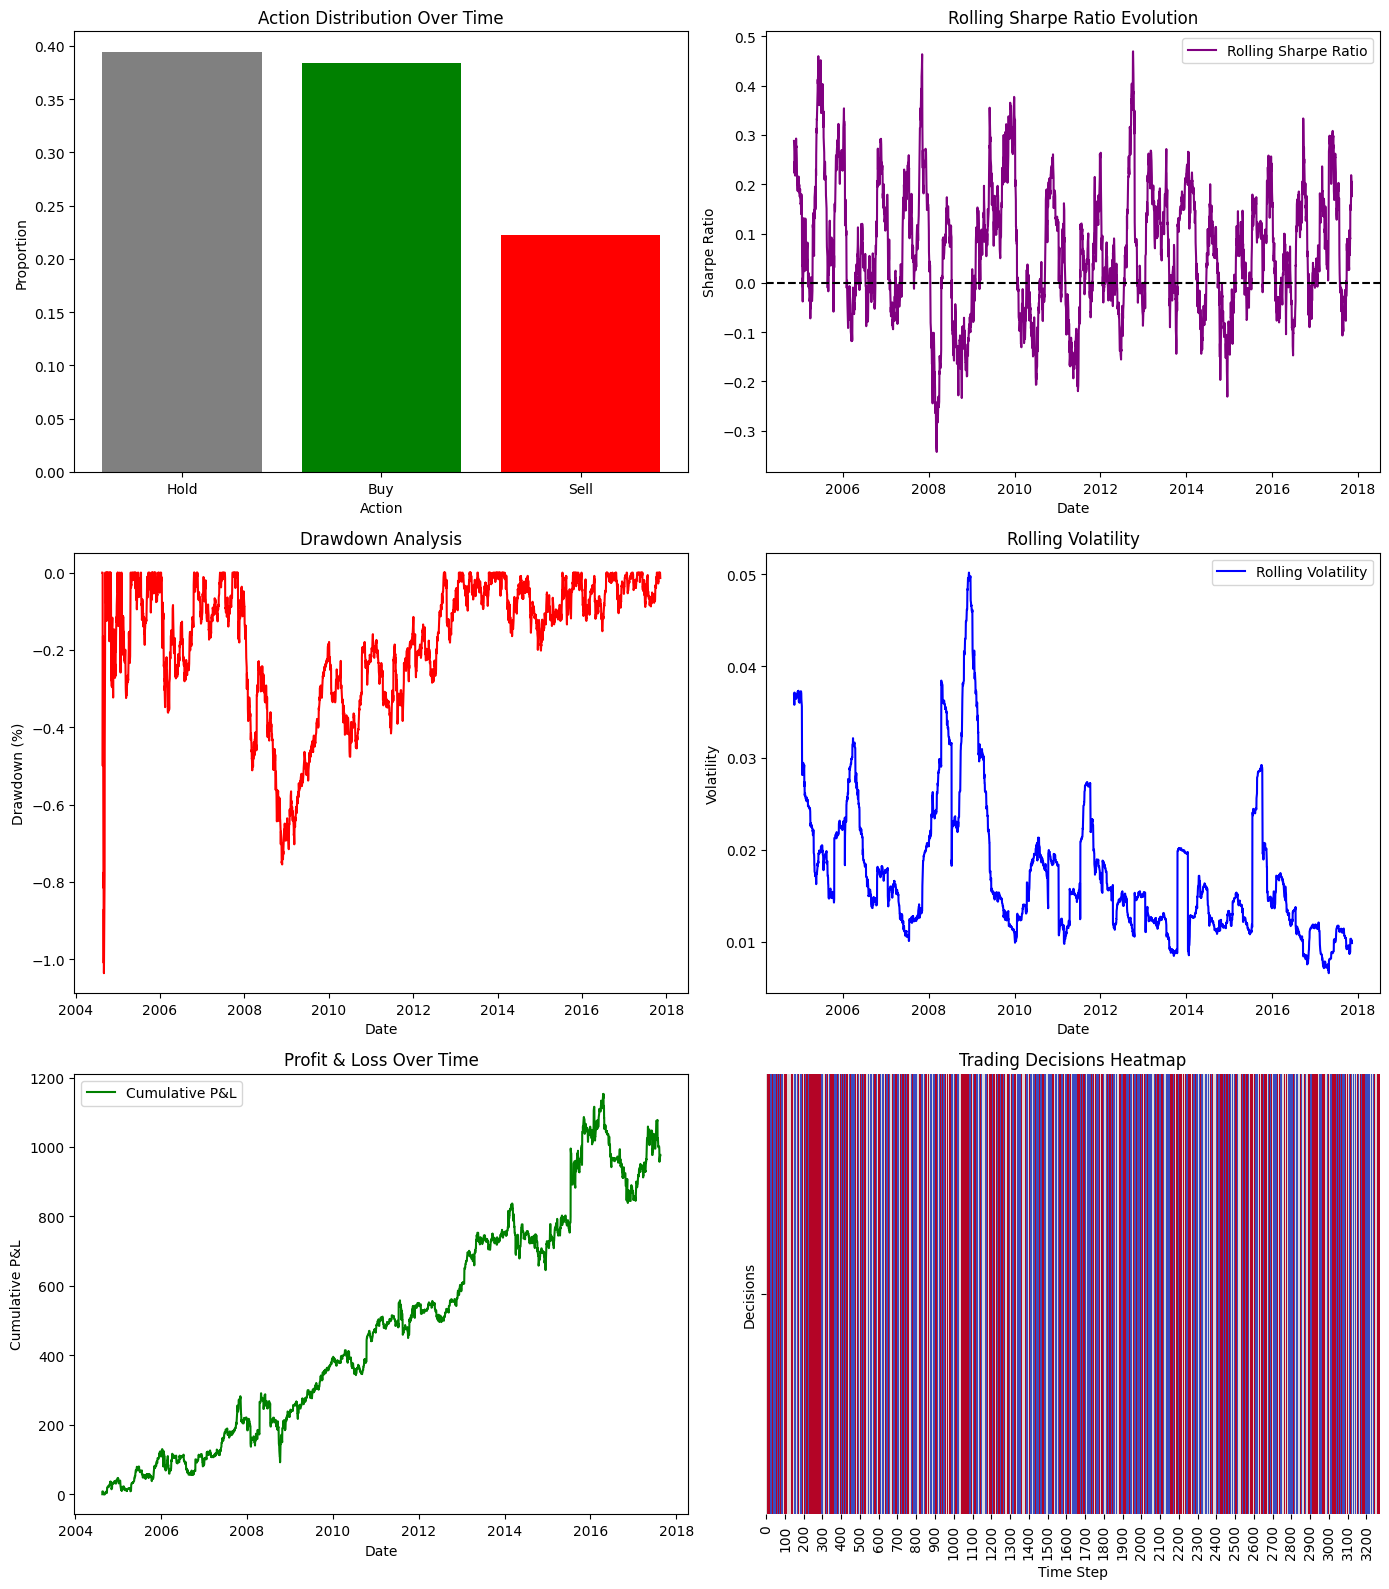

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate rolling Sharpe ratio
def rolling_sharpe(returns, window=60):
    return (returns.rolling(window).mean()) / (returns.rolling(window).std() + 1e-8)

# Function to calculate drawdown
def drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    return (cumulative_returns - peak) / peak

# Function to compute rolling volatility
def rolling_volatility(returns, window=60):
    return returns.rolling(window).std()

# Function to compute cumulative P&L
def cumulative_pnl(decisions, prices):
    prices = np.array(prices)  # Ensure it's an array
    decisions = np.array(decisions)  # Convert to NumPy array

    # Align lengths by trimming the decisions array
    min_length = min(len(prices) - 1, len(decisions))
    pnl = np.cumsum(np.diff(prices[:min_length + 1]) * decisions[:min_length])

    return np.insert(pnl, 0, 0)  # Start with 0 P&L


# Function to plot advanced financial metrics
def plot_advanced_metrics(data, all_rewards, all_decisions):
    prices = data['Close'].values
    dates = data.index
    returns = pd.Series(np.diff(prices) / prices[:-1])

    final_decisions = np.array(all_decisions[-2])

    plt.figure(figsize=(14, 16))

    # 1. Action Distribution Over Time
    plt.subplot(3, 2, 1)
    action_counts = pd.Series(final_decisions).value_counts(normalize=True)
    plt.bar(['Hold', 'Buy', 'Sell'], action_counts, color=['gray', 'green', 'red'])
    plt.title('Action Distribution Over Time')
    plt.xlabel('Action')
    plt.ylabel('Proportion')

    # 2. Sharpe Ratio Evolution
    plt.subplot(3, 2, 2)
    sharpe_ratio = rolling_sharpe(returns)
    plt.plot(dates[1:], sharpe_ratio, label='Rolling Sharpe Ratio', color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Rolling Sharpe Ratio Evolution')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()

    # 3. Drawdown Analysis
    plt.subplot(3, 2, 3)
    cum_returns = np.cumprod(1 + returns) - 1
    drawdowns = drawdown(cum_returns)
    plt.plot(dates[1:], drawdowns, color='red')
    plt.title('Drawdown Analysis')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')

    # 4. Rolling Volatility
    plt.subplot(3, 2, 4)
    vol = rolling_volatility(returns)
    plt.plot(dates[1:], vol, label='Rolling Volatility', color='blue')
    plt.title('Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()

    # 5. Profit & Loss (P&L) Over Time
    plt.subplot(3, 2, 5)
    pnl = cumulative_pnl(final_decisions, prices)
    plt.plot(dates[:len(pnl)], pnl, color='green', label='Cumulative P&L')
    plt.title('Profit & Loss Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative P&L')
    plt.legend()

    # 6. Decision Heatmap
    plt.subplot(3, 2, 6)
    sns.heatmap([final_decisions], cmap='coolwarm', cbar=False, xticklabels=100, yticklabels=['Decisions'])
    plt.title('Trading Decisions Heatmap')
    plt.xlabel('Time Step')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_advanced_metrics(data, all_rewards, all_decisions)

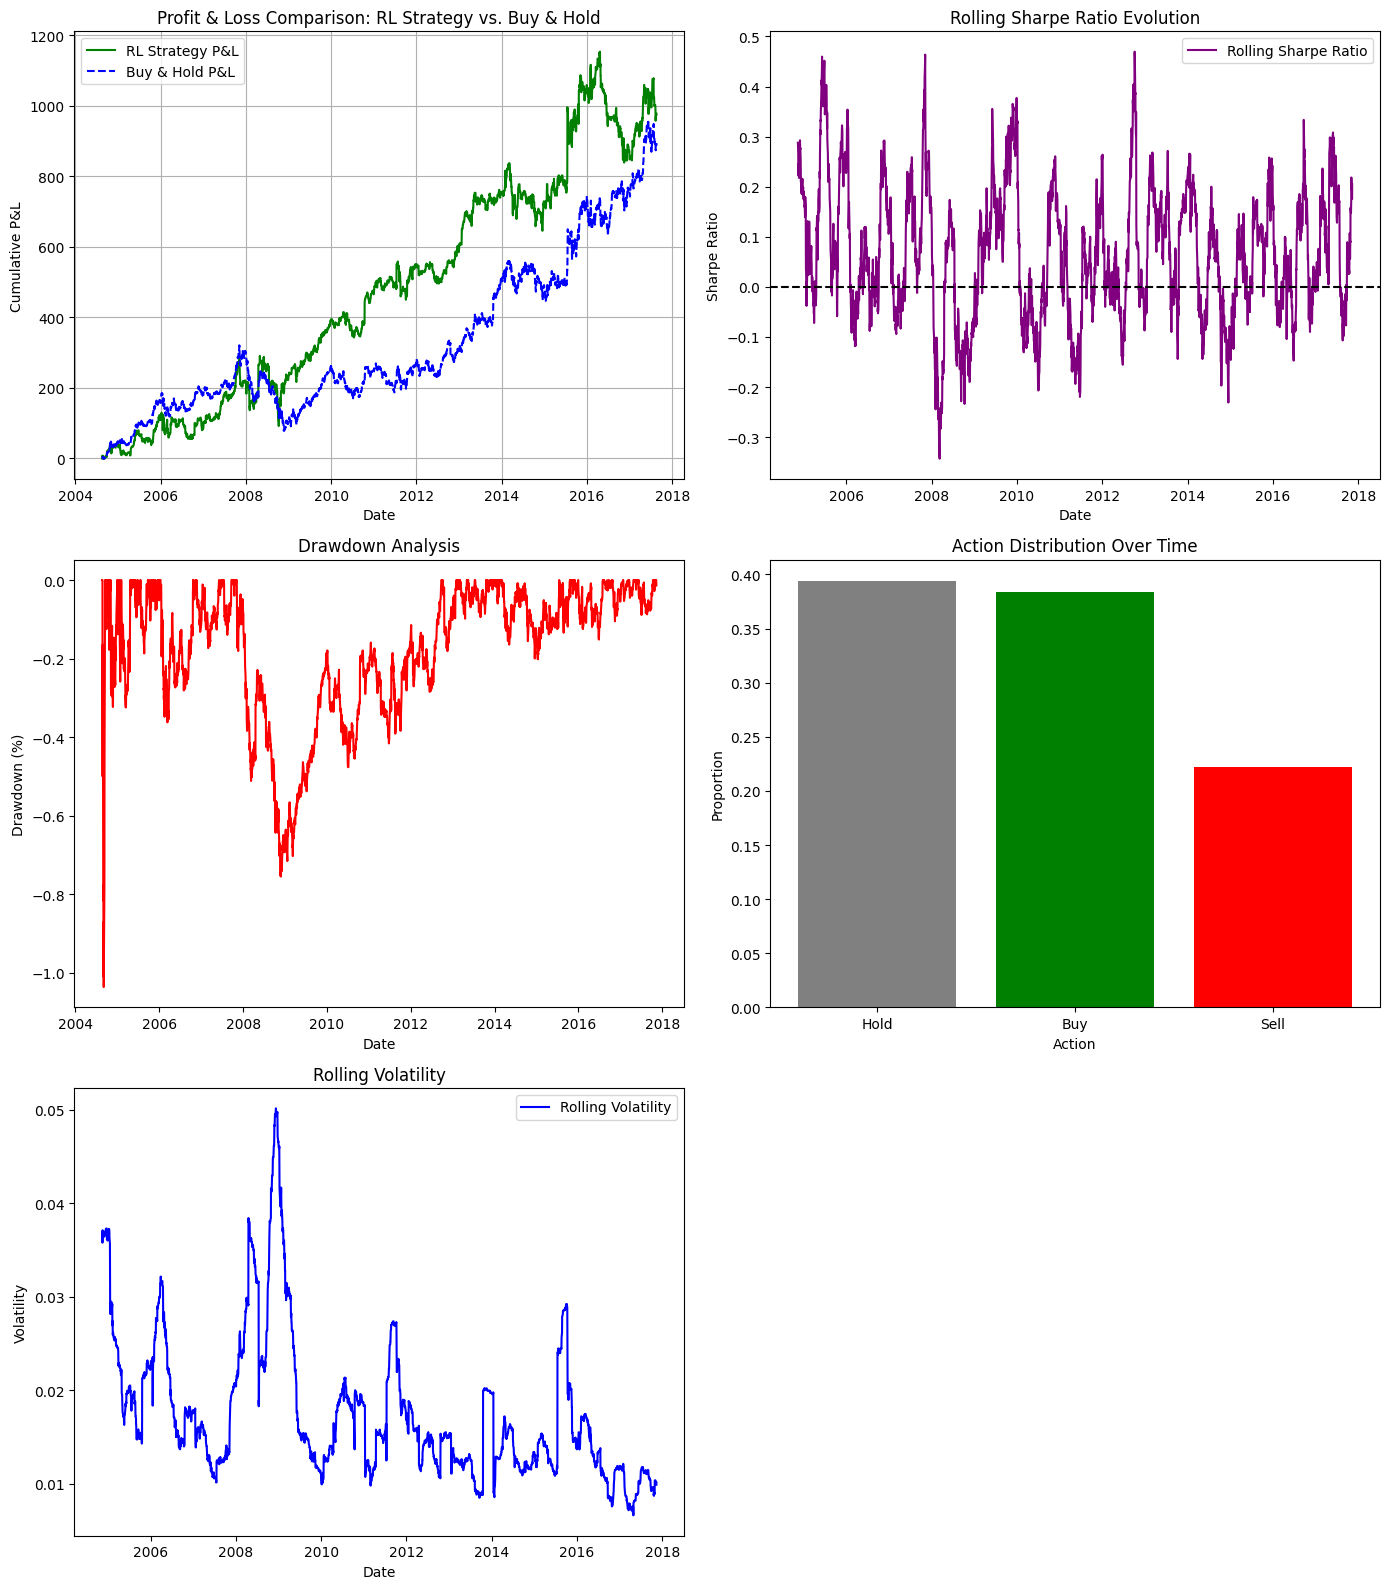

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate rolling Sharpe ratio
def rolling_sharpe(returns, window=60):
    return (returns.rolling(window).mean()) / (returns.rolling(window).std() + 1e-8)

# Function to calculate drawdown
def drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    return (cumulative_returns - peak) / peak

# Function to compute rolling volatility
def rolling_volatility(returns, window=60):
    return returns.rolling(window).std()

# Function to compute cumulative P&L
def cumulative_pnl(decisions, prices):
    prices = np.array(prices)  # Ensure it's an array
    decisions = np.array(decisions)  # Convert to NumPy array

    # Align lengths by trimming the decisions array
    min_length = min(len(prices) - 1, len(decisions))
    pnl = np.cumsum(np.diff(prices[:min_length + 1]) * decisions[:min_length])

    return np.insert(pnl, 0, 0)  # Start with 0 P&L

# Function to compare RL vs. Buy & Hold strategies
def compare_pnl(decisions, prices):
    prices = np.array(prices)
    decisions = np.array(decisions)

    # Align lengths
    min_length = min(len(prices) - 1, len(decisions))
    prices = prices[:min_length + 1]
    decisions = decisions[:min_length]

    # RL Strategy P&L
    rl_pnl = np.cumsum(np.diff(prices) * decisions)

    # Buy & Hold P&L (simply holding from first price)
    buy_hold_pnl = prices[:min_length] - prices[0]

    return np.insert(rl_pnl, 0, 0), np.insert(buy_hold_pnl, 0, 0)

# Function to plot only key metrics
def plot_key_metrics(data, all_decisions):
    prices = data['Close'].values
    dates = data.index
    returns = pd.Series(np.diff(prices) / prices[:-1])

    final_decisions = np.array(all_decisions[-2])

    plt.figure(figsize=(14, 16))

    # 1. Cumulative P&L Comparison
    plt.subplot(3, 2, 1)
    rl_pnl, buy_hold_pnl = compare_pnl(final_decisions, prices)
    plt.plot(dates[:len(rl_pnl)], rl_pnl, label="RL Strategy P&L", color="green")
    plt.plot(dates[:len(buy_hold_pnl)], buy_hold_pnl, label="Buy & Hold P&L", color="blue", linestyle="dashed")
    plt.title("Profit & Loss Comparison: RL Strategy vs. Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Cumulative P&L")
    plt.legend()
    plt.grid(True)

    # 2. Rolling Sharpe Ratio Evolution
    plt.subplot(3, 2, 2)
    sharpe_ratio = rolling_sharpe(returns)
    plt.plot(dates[1:], sharpe_ratio, label='Rolling Sharpe Ratio', color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Rolling Sharpe Ratio Evolution')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()

    # 3. Drawdown Analysis
    plt.subplot(3, 2, 3)
    cum_returns = np.cumprod(1 + returns) - 1
    drawdowns = drawdown(cum_returns)
    plt.plot(dates[1:], drawdowns, color='red')
    plt.title('Drawdown Analysis')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')

    # 4. Action Distribution Over Time
    plt.subplot(3, 2, 4)
    action_counts = pd.Series(final_decisions).value_counts(normalize=True)
    plt.bar(['Hold', 'Buy', 'Sell'], action_counts, color=['gray', 'green', 'red'])
    plt.title('Action Distribution Over Time')
    plt.xlabel('Action')
    plt.ylabel('Proportion')

    # 5. Rolling Volatility
    plt.subplot(3, 2, 5)
    vol = rolling_volatility(returns)
    plt.plot(dates[1:], vol, label='Rolling Volatility', color='blue')
    plt.title('Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate the plots for research paper
plot_key_metrics(data, all_decisions)


# data details

In [34]:
display(data.head())

,Open,High,Low,Close,Volume,OpenInt,Close_Norm,MACD,Signal,RSI,MonthlyReturn,BiMonthlyReturn,QuarterlyReturn,AnnualReturn
Date,,,,,,,,,,,,,,
2004-08-19,50.000,52.03,47.980,50.170,44703800,0,0.047407,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2004-08-20,50.505,54.54,50.250,54.155,22857200,0,0.051172,0.317892,0.063578,0.0,0.0,0.0,0.0,0.0
2004-08-23,55.375,56.74,54.525,54.700,18274400,0,0.051687,0.606805,0.172224,0.0,0.0,0.0,0.0,0.0
2004-08-24,55.620,55.80,51.785,52.435,15262600,0,0.049547,0.645563,0.266892,0.0,0.0,0.0,0.0,0.0
2004-08-25,52.480,54.00,51.940,53.000,9197800,0,0.050081,0.713643,0.356242,0.0,0.0,0.0,0.0,0.0


In [35]:
display(data.tail())

,Open,High,Low,Close,Volume,OpenInt,Close_Norm,MACD,Signal,RSI,MonthlyReturn,BiMonthlyReturn,QuarterlyReturn,AnnualReturn
Date,,,,,,,,,,,,,,
2017-11-06,1049.10,1052.59,1042.00,1042.68,913954,0,0.985250,18.905849,16.162445,64.599078,1.069274,1.496513,1.304787,2.094474
2017-11-07,1049.65,1053.41,1043.00,1052.39,1303832,0,0.994425,19.557893,16.841535,67.021551,1.312061,1.814810,1.494736,1.952788
2017-11-08,1050.05,1062.69,1047.05,1058.29,1214469,0,1.000000,20.316528,17.536533,75.320714,1.545851,1.867440,1.824050,1.896947
2017-11-09,1048.00,1050.88,1035.85,1047.72,1793994,0,0.990012,19.836181,17.996463,67.948826,0.897275,1.619264,1.566146,1.860989
2017-11-10,1043.87,1046.63,1041.22,1044.15,970498,0,0.986639,18.949001,18.186971,78.492951,0.845856,1.540384,1.429510,2.156799


In [36]:
display(len(data))

3333

In [37]:
display(data.describe())

,Open,High,Low,Close,Volume,OpenInt,Close_Norm,MACD,Signal,RSI,MonthlyReturn,BiMonthlyReturn,QuarterlyReturn,AnnualReturn
count,3333.000000,3333.000000,3333.000000,3333.000000,3.333000e+03,3333.0,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,389.993375,393.377354,386.213266,389.855821,7.951734e+06,0.0,0.368383,2.003532,1.981705,54.445602,0.284301,0.418752,0.533445,1.024057
std,235.104757,236.348229,233.616339,235.102374,8.327410e+06,0.0,0.222153,7.059186,6.602584,17.980273,1.041464,1.078225,1.092530,1.308580
min,49.595000,50.870000,47.980000,50.005000,0.000000e+00,0.0,0.047251,-20.243792,-18.169991,0.000000,-2.648626,-2.235497,-2.167121,-1.120944
25%,228.730000,230.930000,226.170000,228.510000,2.535424e+06,0.0,0.215924,-2.224930,-2.071907,41.139886,-0.420009,-0.352371,-0.260390,0.019250
50%,295.980000,298.190000,293.350000,295.610000,5.201600e+06,0.0,0.279328,1.822209,1.729869,54.667177,0.215967,0.293064,0.388711,0.783695
75%,550.370000,554.780000,545.500000,549.490000,1.047400e+07,0.0,0.519224,5.879501,5.686666,67.489962,0.927409,1.121330,1.250418,1.680273
max,1050.050000,1063.620000,1047.050000,1058.290000,8.223340e+07,0.0,1.000000,35.606576,28.492306,98.085642,3.795226,4.981764,4.399600,8.018627
